# Modelo multivariado para o desmatamento

O objetivo principal deste notebook é criar modelos para prever o incremento de desmatamento medido pelo Prodes a partir de outras variáveis. Este notebook também carrega e pré-processa alguns dados (e.g. preços de commodities agropecuárias).

In [3]:
import pandas as pd
import matplotlib.pyplot as pl
import itertools
import numpy as np

import xavy.economy as xe
import prodes as pr

## Funções

In [4]:
def load_cepea_csv(filename, non_float_cols=['Data']):
    """
    Poad and parse agricultural price data from CSV files
    created from CEPEA/ESALQ XLS files.
    """
    
    # Load data:
    df = pd.read_csv(filename)

    # Parse date:
    df['Data'] = pd.to_datetime(df['Data'])

    # Parse values:
    value_cols = list(filter(lambda s: s not in non_float_cols, df.columns))
    for col in value_cols:
        df[col] = df[col].str.replace('.', '').str.replace(',', '.').astype(float)
    return df

In [5]:
def deflate_cepea(df, ipca, skip_cols=['Data', 'À vista US$'], ref_date=None):
    """
    Add a IPCA-corrected column to each price column in CEPEA/ESALQ price 
    DataFrame not in `skip_cols`.
    """
    
    new_df = df.copy()
    
    value_cols = list(filter(lambda s: s not in skip_cols, new_df.columns))
    for col in value_cols:
        new_df[col + ' IPCA'] = xe.deflate_values(new_df['Data'], new_df[col], ipca, ref_date=ref_date, suffix= ' IPCA')
    
    return new_df

In [6]:
def etl_cepea_csv(filename, ipca_df, non_float_cols=['Data'], skip_cols=['Data', 'À vista US$'], ref_date=None):
    """
    Load price data from CEPEA/ESALQ CSV file, parse it, add extra 
    column with BRL inflation-corrected prices using IPCA data and 
    add column with ano Prodes.
    Do not deflate columns in `skip_cols`.
    """
    df = load_cepea_csv(filename, non_float_cols)
    df = deflate_cepea(df, ipca_df, skip_cols, ref_date)
    df['ano_prodes'] = pr.date_series_to_ano_prodes(df['Data'])
    
    return df

In [7]:
def filter_ano_prodes(df, prodes_min=2011, prodes_max=2021):
    return df.loc[(df['ano_prodes'] >= prodes_min) & (df['ano_prodes'] <= prodes_max)]

In [8]:
def build_combinations_df(columns):
    """
    Returns a binary DataFrame with all possible value 
    combination for `columns`. 
    """
    
    i = 0
    df = pd.DataFrame(columns=columns)
    for L in range(1, len(columns)+1):
        for subset in itertools.combinations(columns, L):
            df.loc[i] = 0
            df.loc[i, subset] = 1
            i += 1
    
    return df

In [9]:
def select_hot_columns(df, i):
    """
    Return a list of column names in row `i` (int)
    of DataFrame `df` whose values are 1.
    """
    row = df.loc[i]
    return list(row.loc[row == 1].index)

In [10]:
def trimester_to_date_string(string, trimester_month=3):
    """
    Convert a string like '2º trimestre 1996' to a 
    string in format '%Y-%m-%d'. The month associated
    to the trimester is the `trimester_month`-th 
    in the trimester.
    """
    
    tri   = int(string[:1])
    year  = string[-4:]
    month = (tri - 1) * 3 + trimester_month
    
    return '{:}-{:02d}-01'.format(year, month)
    

def trimester_to_ano_prodes(string):
    """
    Convert a string like '2º trimestre 1996' to a 
    Ano Prodes integer.
    """
    tri = int(string[:1])
    ano = int(string[-4:])
    if tri >= 3:
        ano = ano + 1 
        
    return ano

In [11]:
def load_ibge_pib(filename):
    """
    Load raw Brazil GDP data downloaded from IBGE at
    https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9300-contas-nacionais-trimestrais.html?=&t=series-historicas&utm_source=landing&utm_medium=explica&utm_campaign=pib#evolucao-pib
    
    Returns a DataFrame.
    """
    
    df = pd.read_csv(filename, sep=';', skiprows=1)
    # Ignora primeira coluna, que é título, e última linha, que não tem dados: 
    df = df.iloc[:-1, 1:]

    df = df.transpose().rename({0:'pib_nominal_rs_milhoes'}, axis=1)
    
    return df

def clean_ibge_pib(df, ipca=None):
    """
    Clean a raw IBGE Brazil GDP DataFrame `df` and
    add column 'ano_prodes' and deflated GDP is `ipca` 
    (DataFrame) is provided.
    """
    
    df['data'] = pd.to_datetime(pd.Series(df.index.map(trimester_to_date_string), index=df.index))
    df['ano_prodes'] = pd.Series(df.index.map(trimester_to_ano_prodes), index=df.index)
    
    if type(ipca) != type(None):
        pib_deflac = xe.deflate_values(df['data'], df['pib_nominal_rs_milhoes'], ipca)
        pib_deflac.index = df.index
        df['pib_real_rs_milhoes'] = pib_deflac
        
    return df

def etl_ibge_pib(filename, ipca=None):
    df = load_ibge_pib(filename)
    df = clean_ibge_pib(df, ipca)
    return df

## Carregando e preparando os dados

In [12]:
# Load IPCA data:
ipca = xe.load_extended_ipca('../dados/aux/ipca_ateh_2021-09-01.csv', '2021-08-01')

Loading data from local file...
Last IPCA date:  2021-09-01


In [13]:
# ETL agricultural prices data:
boi   = etl_cepea_csv('../dados/brutos/economicos/boi_gordo_cepea_esalq_2010-2021-out.csv', ipca)
soja  = etl_cepea_csv('../dados/brutos/economicos/soja_bovespa_paranagua_cepea_esalq_2010-2021-out.csv', ipca)
milho = etl_cepea_csv('../dados/brutos/economicos/milho_bovespa_esalq_2010-2021-out.csv', ipca)

# Preço médio no ano:
boi_ano_prodes  = filter_ano_prodes(boi).groupby('ano_prodes')['Valor IPCA'].mean()
boi_ano_prodes.name = 'preco_ipca_boi_gordo'
soja_ano_prodes = filter_ano_prodes(soja).groupby('ano_prodes')['À vista R$ IPCA'].mean()
soja_ano_prodes.name = 'preco_ipca_soja'
milho_ano_prodes = filter_ano_prodes(milho).groupby('ano_prodes')['À vista R$ IPCA'].mean()
milho_ano_prodes.name = 'preco_ipca_milho'

In [14]:
# Dados de desmatamento e orçamento
orcamento_prodes = pd.read_csv('../dados/processed/orcamentos-totalizados_incremento-desmatamento_por_ano-prodes.csv')

In [15]:
# Dados de servidores do IBAMA:
servidores_ibama = pd.read_csv('../dados/processed/numero_servidores_ibama_por_ano_prodes_PortalTransp-PEP.csv')
servidores_ibama = servidores_ibama.set_index('ano_prodes')

In [16]:
# Dados de chuvas:
chuvas = pd.read_csv('../dados/processed/chuvas/precip_amazonica_por_ano_prodes.csv')
chuvas = chuvas.set_index('ano_prodes')

In [17]:
# Dados do PIB:
pib = etl_ibge_pib('../dados/brutos/economicos/pib_a_mercado_ibge_ateh_2_tri_2021.csv', ipca)
pib = pib.groupby('ano_prodes')['pib_real_rs_milhoes'].sum().loc[2011:]

In [18]:
# Junta tudo:
dados_finais = orcamento_prodes.join(servidores_ibama, on='ano_prodes').join(pib, on='ano_prodes').join(boi_ano_prodes, on='ano_prodes').join(soja_ano_prodes, on='ano_prodes').join(milho_ano_prodes, on='ano_prodes').join(chuvas, on='ano_prodes')

In [19]:
dados_finais

,ano_prodes,orcamento_geral,orcamento_conservacao,orcamento_geral_mais_glos,Incremento,componente_geral,componente_especifico,componente_glo,n_servidores_ibama,pib_real_rs_milhoes,preco_ipca_boi_gordo,preco_ipca_soja,preco_ipca_milho,precipitacao_mm
0,2011,1.011250e+09,3.663152e+08,1.011250e+09,5611.1,6.449353e+08,3.663152e+08,0.000000e+00,5520.000000,7.655727e+06,186.356758,88.354938,52.036644,2067.574995
1,2012,1.137326e+09,4.586569e+08,1.137326e+09,4458.2,6.786687e+08,4.586569e+08,0.000000e+00,5145.000000,7.966051e+06,169.371704,96.842894,49.697339,2006.215482
2,2013,1.144752e+09,6.011797e+08,1.144752e+09,5413.4,5.435724e+08,6.011797e+08,0.000000e+00,4593.000000,8.294534e+06,159.508717,117.189425,49.980208,2046.954687
3,2014,1.090386e+09,5.826859e+08,1.090386e+09,5126.8,5.076999e+08,5.826859e+08,0.000000e+00,4940.416667,8.603881e+06,177.777393,111.392653,41.854949,2177.431806
4,2015,1.048886e+09,5.721006e+08,1.048886e+09,6143.7,4.767852e+08,5.721006e+08,0.000000e+00,4853.833333,8.481378e+06,201.965346,93.636691,37.386148,1931.411039
5,2016,8.926894e+08,4.241185e+08,8.926894e+08,7266.8,4.685709e+08,4.241185e+08,0.000000e+00,4522.583333,8.012482e+06,197.369676,107.194201,52.798539,1618.352017
6,2017,8.327487e+08,3.399432e+08,8.327487e+08,7299.2,4.928055e+08,3.399432e+08,0.000000e+00,4078.000000,7.971509e+06,177.151503,92.035472,43.614239,2233.120335
7,2018,8.179171e+08,2.934938e+08,8.179171e+08,7386.0,5.244233e+08,2.934938e+08,0.000000e+00,3925.833333,8.156258e+06,170.938543,93.225834,42.096348,2019.307386
8,2019,8.113249e+08,3.052823e+08,8.120012e+08,11043.9,5.060426e+08,3.052823e+08,6.762607e+05,3973.000000,8.309819e+06,174.111995,95.371189,44.152874,2272.093329
9,2020,7.469611e+08,2.928918e+08,8.866990e+08,10587.9,4.540693e+08,2.928918e+08,1.397380e+08,3525.500000,8.247243e+06,215.857086,107.079482,53.114776,2073.033919


In [20]:
# Adiciona dummy para o Bolsonaro:
#dados_finais['bolsonaro'] = 0
#dados_finais.loc[dados_finais['ano_prodes'] >= 2019, 'bolsonaro'] = 1
#dados_finais.loc[dados_finais['ano_prodes'] == 2019, 'bolsonaro'] = 0.5

## Relação entre as variáveis

In [19]:
# Colunas de alvo e possíveis variáveis do modelo:
y_col  = 'Incremento'
all_X_cols = list(filter(lambda s: s not in ['ano_prodes', 'Incremento', 'componente_geral', 'componente_especifico', 'componente_glo', 'orcamento_conservacao'], dados_finais.columns))

In [20]:
# Matriz de correlação entre variáveis independentes:
dados_finais[all_X_cols].corr().style.background_gradient(vmin=-1, vmax=1, cmap='coolwarm_r')

,orcamento_geral,orcamento_geral_mais_glos,n_servidores_ibama,pib_real_rs_milhoes,preco_ipca_boi_gordo,preco_ipca_soja,preco_ipca_milho,precipitacao_mm
orcamento_geral,1.000000,0.712091,0.853579,-0.148163,-0.654890,-0.425873,-0.534801,-0.106398
orcamento_geral_mais_glos,0.712091,1.000000,0.611263,0.205960,0.018355,0.273139,0.148637,-0.112356
n_servidores_ibama,0.853579,0.611263,1.000000,-0.389442,-0.459828,-0.426604,-0.367228,-0.185919
pib_real_rs_milhoes,-0.148163,0.205960,-0.389442,1.000000,0.406343,0.569603,0.183298,0.168739
preco_ipca_boi_gordo,-0.654890,0.018355,-0.459828,0.406343,1.000000,0.832158,0.867695,-0.134530
preco_ipca_soja,-0.425873,0.273139,-0.426604,0.569603,0.832158,1.000000,0.892521,-0.064731
preco_ipca_milho,-0.534801,0.148637,-0.367228,0.183298,0.867695,0.892521,1.000000,-0.118203
precipitacao_mm,-0.106398,-0.112356,-0.185919,0.168739,-0.134530,-0.064731,-0.118203,1.000000


## Modelo atemporal

Este é o modelo principal do projeto: ele prevê o desmatamento a partir das demais variáveis, ignorando a dependência temporal.

### Baseline

Vamos calcular o desvio padrão do incremento de desmatamento: esse é o mínimo necessário a ser obtido por um modelo explicativo.

In [21]:
desmatamento_medio = dados_finais['Incremento'].mean()
erro_basico        = dados_finais['Incremento'].std()
residuos           = dados_finais['Incremento'] - desmatamento_medio
print('Erro do modelo base (média do incremento): {:.2f}'.format(erro_basico))

Erro do modelo base (média do incremento): 2613.67


### Seleção de modelo

Vamos utilizar validação cruzada para identificar o conjunto de variáveis que melhor explicam o incremento de desmatamento através de um modelo linear.

In [22]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

In [23]:
model = LinearRegression()
splitter = KFold(5, shuffle=True, random_state=287)

print('Anos utilizados como teste:')
for train, test in splitter.split(dados_finais):
    print(dados_finais['ano_prodes'].iloc[test].values, end=' ')

Anos utilizados como teste:
[2011 2017 2019] [2012 2015] [2014 2020] [2016 2021] [2013 2018] 

In [24]:
# Cria tabela com todas as combinações possíveis de variáveis:
variable_combinations = build_combinations_df(all_X_cols)

# Calcula e registra a performance (nas amostras de validação) do modelo, para cada conjunto de variáveis explicativas, em esquema de validação cruzada:
n_var_combinations = len(variable_combinations)
print('# combinações:', n_var_combinations)
for i in range(n_var_combinations):
    X_cols   = select_hot_columns(variable_combinations, i)
    scores   = -cross_val_score(model, dados_finais[X_cols], dados_finais[y_col], scoring='neg_root_mean_squared_error', cv=splitter)
    variable_combinations.loc[i, 'rmse'] = np.mean(scores)
    variable_combinations.loc[i, 'rmse_dev'] = np.std(scores)
    variable_combinations.loc[i, 'rmse_dev_mean'] = np.std(scores) / np.sqrt(len(scores))

# combinações: 255


In [25]:
# Ordena os resultados pela performance na amostra de validação:
variable_importance = variable_combinations.sort_values('rmse', ascending=True)
variable_importance['n_variaveis'] = variable_importance[all_X_cols].sum(axis=1)

# Adiciona indicadores da presença de variáveis de um determinado conjunto:
variable_importance['governo']  = (variable_importance['orcamento_geral'] | variable_importance['orcamento_geral_mais_glos'] | variable_importance['n_servidores_ibama']).astype(int)
variable_importance['economia'] = (variable_importance['preco_ipca_boi_gordo'] | variable_importance['preco_ipca_milho'] | variable_importance['preco_ipca_soja']).astype(int)

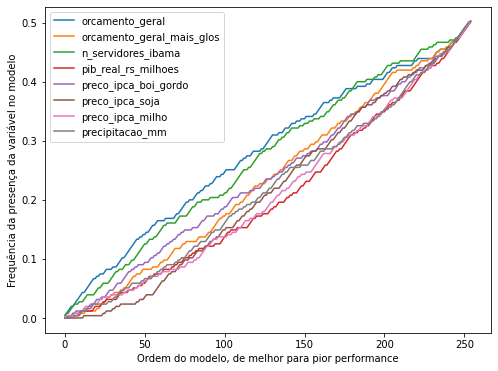

In [26]:
# Frequência acumulada da presença das variáveis nos modelos ordenados por performance.
# Variáveis mais importantes disparam na frente antes das demais. Como todas as variáveis aparecem, no total, 
# o mesmo número de vezes, as frequências convergem para o mesmo valor quando todos os modelos são inclusos.
variable_freq = variable_importance[all_X_cols].cumsum() / len(variable_importance)
pl.figure(figsize=(8,6))
for col in all_X_cols:
    pl.plot(variable_freq[col].values, label=col)
pl.legend()
pl.xlabel('Ordem do modelo, de melhor para pior performance')
pl.ylabel('Frequência da presença da variável no modelo')
pl.show()

O gráfico acima mostra que as variáveis `orcamento_geral` e `n_servidores_ibama` aparecem com mais frequência nos modelos mais bem sucedidos.

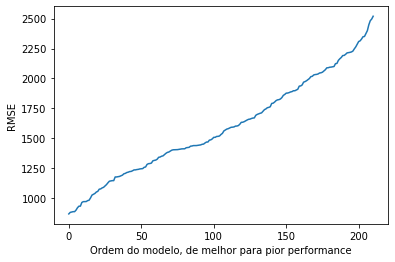

In [27]:
# Evolução da raiz do erro quadrático médio em função dos modelos ordenados por performance:
good_variable_importance = variable_importance.loc[variable_importance['rmse'] < erro_basico]
pl.plot(good_variable_importance['rmse'].values)
pl.xlabel('Ordem do modelo, de melhor para pior performance')
pl.ylabel('RMSE')
pl.show()

Abaixo nós selecionamos os modelos próximos do melhor modelo, dentro de um intervalo de confiança dado pelo desvio padrão do erro do melhor modelo, calculado com validação cruzada.

In [28]:
# Interval around best model, in # of std. dev.:
n_sigma = np.sqrt(2)

best_rmse = variable_importance.iloc[0]['rmse']
max_rmse = best_rmse + n_sigma * variable_importance.iloc[0]['rmse_dev_mean']
min_rmse = best_rmse - n_sigma * variable_importance.iloc[0]['rmse_dev_mean']
best_models = variable_importance.loc[variable_importance['rmse'] < max_rmse]
print('# melhores modelos: {} de {} ({:.1f}%)'.format(len(best_models), len(variable_importance), len(best_models)/len(variable_importance) * 100))

# melhores modelos: 37 de 255 (14.5%)


In [29]:
# Frequency of each variable in the best models:
test_vars   = ['orcamento_geral', 'n_servidores_ibama', 'preco_ipca_boi_gordo', 'preco_ipca_soja', 'preco_ipca_milho', 'precipitacao_mm', 'orcamento_geral_mais_glos']
vars_labels = ['Orçamento MMA', 'Núm. servidores IBAMA', 'Preço do Boi', 'Preço da soja', 'Preço do milho', 'Chuvas', 'Orçamento MMA + GLOs']
col_namer   = {k:v for k,v in zip(test_vars, vars_labels)}
var_freq_best_models = best_models[all_X_cols].mean().sort_values().rename(col_namer) * 100
var_freq_best_models

Preço da soja            16.216216
Preço do milho           27.027027
pib_real_rs_milhoes      29.729730
Orçamento MMA + GLOs     32.432432
Chuvas                   32.432432
Preço do Boi             43.243243
Núm. servidores IBAMA    56.756757
Orçamento MMA            70.270270
dtype: float64

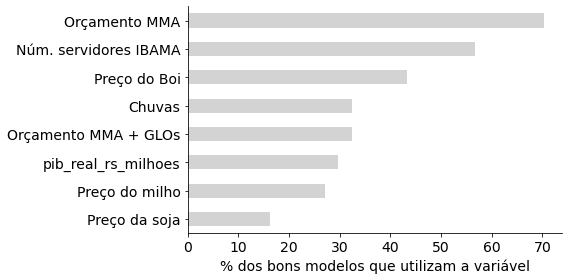

In [31]:
# Plot the numbers above:
pl.figure(figsize=(8,4))
var_freq_best_models.plot(kind='barh', color='lightgray')
pl.tick_params(labelsize=14)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.xlabel('% dos bons modelos que utilizam a variável', fontsize=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/presenca_variavel_melhores_modelos_1.4-sigma.png')
pl.show()

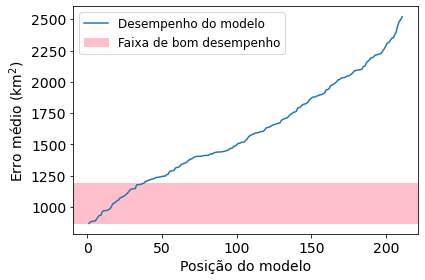

In [32]:
# Graphically represent the range of best models:
pl.figure(figsize=(6,4))
x = range(1, 1+ len(good_variable_importance))
pl.axhspan(best_rmse, max_rmse, color='pink', label='Faixa de bom desempenho')
pl.plot(x, good_variable_importance['rmse'], label='Desempenho do modelo')
pl.tick_params(labelsize=14)
pl.xlabel('Posição do modelo', fontsize=14)
pl.ylabel('Erro médio ($\mathrm{km^2}$)', fontsize=14)
pl.legend(fontsize=12)
pl.tight_layout()
#pl.savefig('../resultados/plots/desempenho_melhores_modelos.png')
pl.show()

In [34]:
best_models

,orcamento_geral,orcamento_geral_mais_glos,n_servidores_ibama,pib_real_rs_milhoes,preco_ipca_boi_gordo,preco_ipca_soja,preco_ipca_milho,precipitacao_mm,rmse,rmse_dev,rmse_dev_mean,n_variaveis,governo,economia
9,1,0,1,0,0,0,0,0,869.411864,504.735739,225.724684,2.0,1,0
45,1,0,1,0,0,0,1,0,882.239024,506.845095,226.668017,3.0,1,1
10,1,0,0,1,0,0,0,0,885.379912,508.637918,227.469792,2.0,1,0
43,1,0,1,0,1,0,0,0,888.229737,723.943825,323.757521,3.0,1,1
36,1,1,1,0,0,0,0,0,888.239616,577.165808,258.116396,3.0,1,0
58,0,1,1,0,1,0,0,0,901.205990,667.584327,298.552787,3.0,1,1
116,1,0,1,0,0,0,1,1,920.962307,427.878162,191.352931,4.0,1,1
11,1,0,0,0,1,0,0,0,934.025652,625.302948,279.643980,2.0,1,1
0,1,0,0,0,0,0,0,0,934.159616,508.874684,227.575677,1.0,1,0
42,1,0,1,1,0,0,0,0,964.997120,574.413282,256.885429,3.0,1,0


### Parâmetros do modelo

Aqui nós vemos qual é a contribuição (se positiva ou negativa) de algumas variáveis de interesse para a previsão final do desmatamento.m

In [93]:
from sklearn.model_selection import cross_val_predict

In [94]:
model = LinearRegression()

In [95]:
# Orçamento do MMA e # servidores do IBAMA colaboram para reduzir o desmatamento:
dump = model.fit(dados_finais[['orcamento_geral', 'n_servidores_ibama']], dados_finais['Incremento'])
model.coef_

array([-1.05662022e-05, -1.03170709e+00])

In [96]:
# A contribuição das GLOs vai no sentido de aumentar o desmatamento:
dump = model.fit(dados_finais[['orcamento_geral', 'n_servidores_ibama', 'componente_glo']], dados_finais['Incremento'])
model.coef_

array([-8.66602894e-06, -1.04158951e+00,  3.98366498e-06])

### Comparação do modelo e dados reais

Aqui comparamos as previsões de um dado modelo com os dados reais de desmatamento.

In [186]:
# Melhores variáveis explicativas:
best_var_set = variable_importance.iloc[0]
best_var_set = list(filter(lambda s: s not in ('governo', 'economia', 'n_variaveis'), best_var_set.loc[best_var_set == 1].index))
print(best_var_set)

['orcamento_geral', 'n_servidores_ibama']


In [187]:
dados_anteriores = dados_finais.loc[dados_finais['ano_prodes'] < 2019]
X_vars = best_var_set
#X_vars = ['orcamento_geral', 'n_servidores_ibama']
#X_vars = ['orcamento_geral']
#X_vars = ['n_servidores_ibama']

In [188]:
dump = model.fit(dados_anteriores[X_vars], dados_anteriores['Incremento'])
#dump = model.fit(dados_finais[X_vars], dados_finais['Incremento'])

In [189]:
prev_model = model.predict(dados_finais[X_vars])

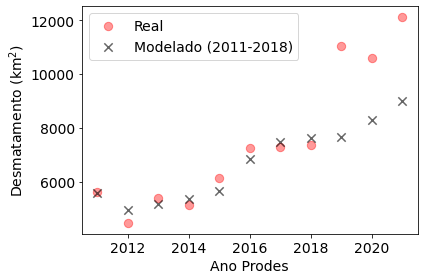

In [211]:
pl.scatter(dados_finais['ano_prodes'], dados_finais['Incremento'], alpha=0.4, color='r', s=70, label='Real')
pl.scatter(dados_finais['ano_prodes'], prev_model, alpha=0.6, color='k', marker='x', label='Modelado (2011-2018)', s=70)
pl.tick_params(labelsize=14)
pl.legend(fontsize=14)
pl.xlabel('Ano Prodes', fontsize=14)
pl.ylabel('Desmatamento ($\mathrm{km^2}$)', fontsize=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/desmatamento_real_e_previsao_modelo_2011-2018.png')
pl.show()

## Método SHAP

Caso haja interesse em rodar esta seção do notebook, favor instalar o código SHAP com o comando (linux/mac): `pip install shap` ou um análogo para o Anaconda.

Maiores informações sobre o pacote SHAP: <https://shap.readthedocs.io/en/latest/>

In [102]:
import shap

In [103]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

In [104]:
# Colunas de alvo e possíveis variáveis do modelo:
y_col  = 'Incremento'
all_X_cols = list(filter(lambda s: s not in ['ano_prodes', 'Incremento', 'componente_geral', 'componente_especifico', 'componente_glo', 'orcamento_conservacao', 'orcamento_geral_mais_glos'], dados_finais.columns))

In [147]:
model = LinearRegression()
splitter = KFold(5, shuffle=True, random_state=287)

shap_values  = []
cross_test_X = []
print('Anos utilizados como teste:')
for train, test in splitter.split(dados_finais):
    print(dados_finais['ano_prodes'].iloc[test].values, end=' ')
    
    # Split data:
    train_df = dados_finais.iloc[train]
    test_df  = dados_finais.iloc[test]
    X_train  = train_df[all_X_cols]
    X_test   = test_df[all_X_cols]
    
    # Fit the model:
    dump = model.fit(X_train, train_df[y_col])
    
    # Build the SHAP explainer:
    masker    = shap.maskers.Independent(X_train)
    explainer = shap.LinearExplainer(model, masker)
    # Get the shap values:
    shap_values = shap_values + [explainer.shap_values(X_test)]
    # Create organized test set:
    cross_test_X = cross_test_X + [X_test.values]

# Join results for all splits:
shap_values  = np.concatenate(shap_values)
cross_test_X = np.concatenate(cross_test_X) 

Anos utilizados como teste:
[2011 2017 2019] [2012 2015] [2014 2020] [2016 2021] [2013 2018] 

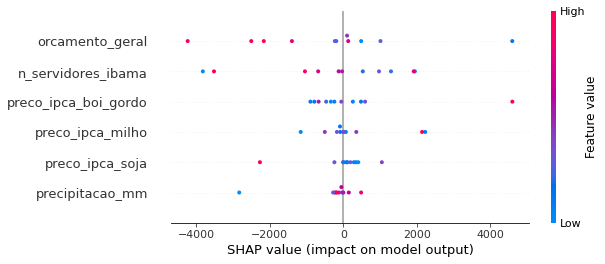

In [149]:
shap.summary_plot(shap_values, cross_test_X, feature_names=all_X_cols)

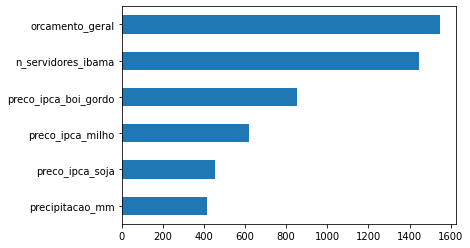

In [166]:
pd.Series(np.abs(shap_values).mean(axis=0), index=all_X_cols).sort_values().plot(kind='barh')
pl.show()

## Testes de causalidade de granger

Os testes de granger indicam que o orçamento geral e número de servidores do IBAMA (especialmente, pois tem significância estatística) tem maiores chances de explicar o desmatamento.

Caso haja interesse em rodar esta seção, favor instalar o pacote `statsmodels`.

In [105]:
import utils as xu
from statsmodels.tsa.stattools import grangercausalitytests

In [106]:
test_vars = list(filter(lambda s: s not in ['ano_prodes', 'Incremento'], dados_finais.columns))

In [107]:
for col in test_vars:
    print('\n' + xu.Bold(col))
    dump = grangercausalitytests(dados_finais[['Incremento', col]], 1)


orcamento_geral

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3977  , p=0.2757  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=1.9968  , p=0.1576  , df=1
likelihood ratio test: chi2=1.8205  , p=0.1773  , df=1
parameter F test:         F=1.3977  , p=0.2757  , df_denom=7, df_num=1

orcamento_conservacao

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2233  , p=0.6509  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=0.3190  , p=0.5722  , df=1
likelihood ratio test: chi2=0.3141  , p=0.5752  , df=1
parameter F test:         F=0.2233  , p=0.6509  , df_denom=7, df_num=1

orcamento_geral_mais_glos

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5019  , p=0.5016  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=0.7170  , p=0.3971  , df=1
likelihood ratio test: chi2=0.6925  , p=0.4053  , df=1
parameter F test:         F=0.5019  , p=0.5016  , df_denom=7, df_num=1

componente_geral

Granger Causality
nu

## Gráficos temporais e correlação

Aqui criamos gráficos que comparam a evolução temporal das variáveis com a evolução temporal do desmatamento.

Também calculamos a correlação entre essas variáveis.

### Gráficos

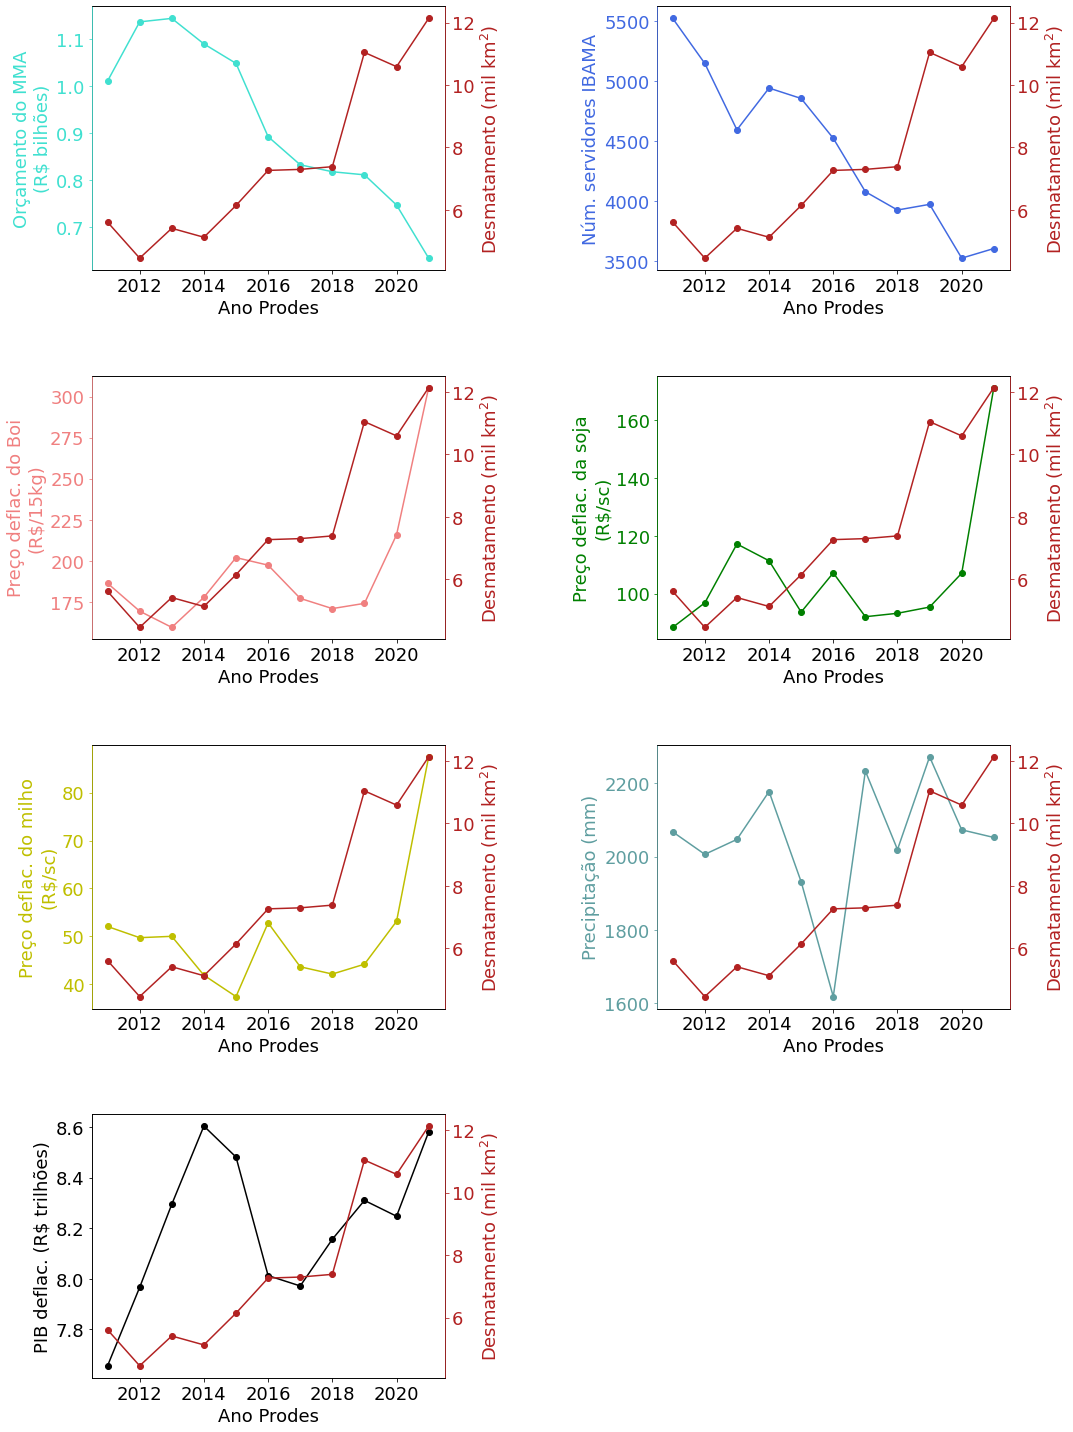

In [21]:
test_vars   = ['orcamento_geral', 'n_servidores_ibama', 'preco_ipca_boi_gordo', 'preco_ipca_soja', 'preco_ipca_milho', 'precipitacao_mm', 'pib_real_rs_milhoes']
vars_labels = ['Orçamento do MMA\n(R$ bilhões)', 'Núm. servidores IBAMA', 'Preço deflac. do Boi\n(R$/15kg)', 'Preço deflac. da soja\n(R$/sc)', 'Preço deflac. do milho\n(R$/sc)', 'Precipitação (mm)', 'PIB deflac. (R$ trilhões)']
colors      = ['turquoise', 'royalblue', 'lightcoral', 'g', 'y', 'cadetblue', 'k']
fatores     = [1e-9, 1, 1, 1, 1, 1, 1e-6]
fontsize    = 18
#fig, ax1 = pl.subplots(figsize=(6.5,4))
fig = pl.figure(figsize=(15, 20))

for i in range(len(test_vars)):

    ax1 = pl.subplot(4, 2, i + 1)
    col = test_vars[i]
    label = vars_labels[i]
    left_color = colors[i]
    fator = fatores[i]
    
    #ax1.plot(dados_finais['ano_prodes'].iloc[1:], dados_finais['n_servidores_ibama'].iloc[:-1], color=left_color, marker='o')
    ax1.plot(dados_finais['ano_prodes'], dados_finais[col] * fator, color=left_color, marker='o')
    ax1.set_xlabel('Ano Prodes', fontsize=fontsize)
    ax1.set_ylabel(label, color=left_color, fontsize=fontsize)
    ax1.tick_params(axis='y', labelcolor=left_color, labelsize=fontsize, color=left_color)
    ax1.tick_params(axis='x', labelsize=fontsize)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    right_color = 'firebrick'
    ax2.plot(dados_finais['ano_prodes'], dados_finais['Incremento'] / 1000, color='firebrick', marker='o')
    ax2.set_ylabel('Desmatamento (mil $\mathrm{km^2}$)', color=right_color, fontsize=fontsize)
    ax2.tick_params(axis='y', labelcolor=right_color, labelsize=fontsize, color=right_color)

    ax2.spines['right'].set_color(right_color)
    ax2.spines['left'].set_color(left_color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(wspace=0.6, hspace=0.4)
#pl.savefig('../resultados/plots/relacao_orcamento_especifico_desmatamento_line.png')
pl.show()

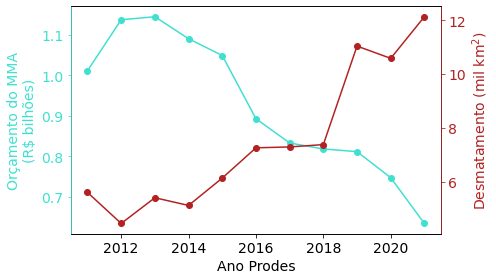

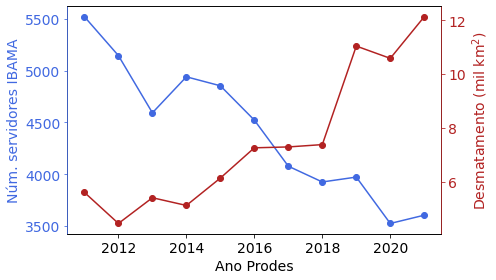

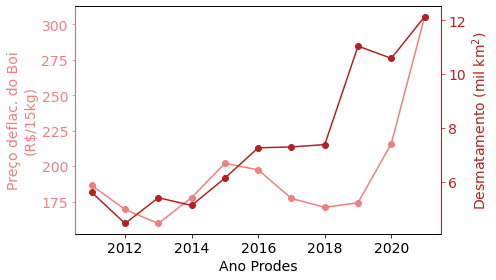

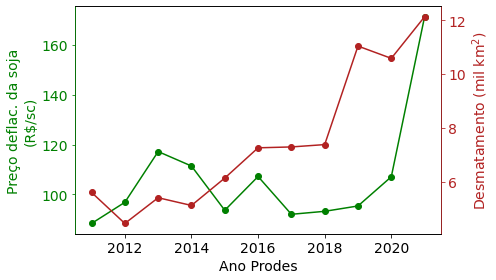

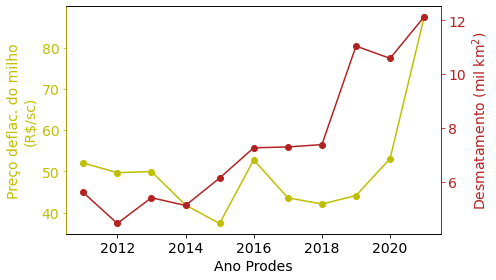

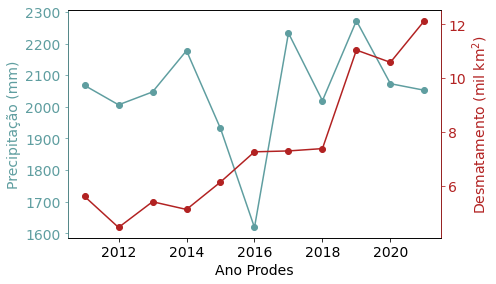

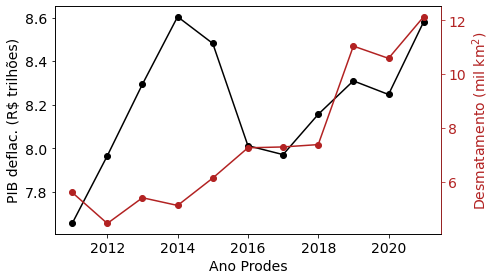

In [28]:
test_vars   = ['orcamento_geral', 'n_servidores_ibama', 'preco_ipca_boi_gordo', 'preco_ipca_soja', 'preco_ipca_milho', 'precipitacao_mm', 'pib_real_rs_milhoes']
vars_labels = ['Orçamento do MMA\n(R$ bilhões)', 'Núm. servidores IBAMA', 'Preço deflac. do Boi\n(R$/15kg)', 'Preço deflac. da soja\n(R$/sc)', 'Preço deflac. do milho\n(R$/sc)', 'Precipitação (mm)', 'PIB deflac. (R$ trilhões)']
colors      = ['turquoise', 'royalblue', 'lightcoral', 'g', 'y', 'cadetblue', 'k']
fatores     = [1e-9, 1, 1, 1, 1, 1, 1e-6]
fontsize    = 14
#fig, ax1 = pl.subplots(figsize=(6.5,4))


for i in range(len(test_vars)):
    
    fig = pl.figure(figsize=(7, 4))
    
    ax1 = pl.gca()
    col = test_vars[i]
    label = vars_labels[i]
    left_color = colors[i]
    fator = fatores[i]
    
    #ax1.plot(dados_finais['ano_prodes'].iloc[1:], dados_finais['n_servidores_ibama'].iloc[:-1], color=left_color, marker='o')
    ax1.plot(dados_finais['ano_prodes'], dados_finais[col] * fator, color=left_color, marker='o')
    ax1.set_xlabel('Ano Prodes', fontsize=fontsize)
    ax1.set_ylabel(label, color=left_color, fontsize=fontsize)
    ax1.tick_params(axis='y', labelcolor=left_color, labelsize=fontsize, color=left_color)
    ax1.tick_params(axis='x', labelsize=fontsize)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    right_color = 'firebrick'
    ax2.plot(dados_finais['ano_prodes'], dados_finais['Incremento'] / 1000, color='firebrick', marker='o')
    ax2.set_ylabel('Desmatamento (mil $\mathrm{km^2}$)', color=right_color, fontsize=fontsize)
    ax2.tick_params(axis='y', labelcolor=right_color, labelsize=fontsize, color=right_color)

    ax2.spines['right'].set_color(right_color)
    ax2.spines['left'].set_color(left_color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #pl.savefig('../resultados/plots/relacao_{}_desmatamento_line.png'.format(col))
#pl.show()

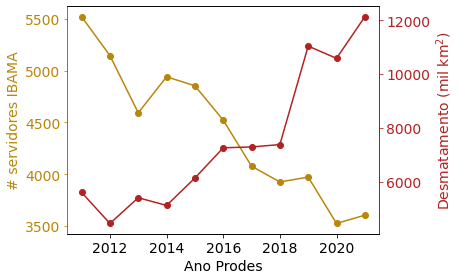

In [78]:
fig, ax1 = pl.subplots(figsize=(6.5,4))

left_color = 'darkgoldenrod'
#ax1.plot(dados_finais['ano_prodes'].iloc[1:], dados_finais['n_servidores_ibama'].iloc[:-1], color=left_color, marker='o')
ax1.plot(dados_finais['ano_prodes'], dados_finais['n_servidores_ibama'], color=left_color, marker='o')
ax1.set_xlabel('Ano Prodes', fontsize=14)
ax1.set_ylabel('# servidores IBAMA', color=left_color, fontsize=14)
ax1.tick_params(axis='y', labelcolor=left_color, labelsize=14, color=left_color)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

right_color = 'firebrick'
ax2.plot(dados_finais['ano_prodes'], dados_finais['Incremento'], color='firebrick', marker='o')
ax2.set_ylabel('Desmatamento (mil $\mathrm{km^2}$)', color=right_color, fontsize=14)
ax2.tick_params(axis='y', labelcolor=right_color, labelsize=14, color=right_color)

ax2.spines['right'].set_color(right_color)
ax2.spines['left'].set_color(left_color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#pl.savefig('../resultados/plots/relacao_orcamento_especifico_desmatamento_line.png')
pl.show()

### Correlações

In [30]:
import correlation as xc

In [29]:
(dados_finais[['Incremento'] + test_vars].corr().rename(dict(zip(test_vars, vars_labels))).iloc[1:, 0:1] * 100).round(1)

,Incremento
Orçamento do MMA\n(R$ bilhões),-91.3
Núm. servidores IBAMA,-84.9
Preço deflac. do Boi\n(R$/15kg),67.1
Preço deflac. da soja\n(R$/sc),51.5
Preço deflac. do milho\n(R$/sc),56.6
Precipitação (mm),19.8
PIB deflac. (R$ trilhões),34.1


In [32]:
test_vars

['orcamento_geral',
 'n_servidores_ibama',
 'preco_ipca_boi_gordo',
 'preco_ipca_soja',
 'preco_ipca_milho',
 'precipitacao_mm',
 'pib_real_rs_milhoes']

In [39]:
p_values = []
for var in test_vars:
    print(var, end=' ')
    actual_corr = xc.compute_correlation(dados_finais['Incremento'], dados_finais[var])
    corr_sample = xc.bootstrap_correlation(dados_finais['Incremento'], dados_finais[var])
    p_value = (np.abs(corr_sample) > np.abs(actual_corr)).sum() / len(corr_sample)
    p_values.append(p_value)

orcamento_geral n_servidores_ibama preco_ipca_boi_gordo preco_ipca_soja preco_ipca_milho precipitacao_mm pib_real_rs_milhoes 

In [45]:
pd.DataFrame({'valor_p': np.array(p_values) * 100}, index=vars_labels)

,valor_p
Orçamento do MMA\n(R$ bilhões),0.01
Núm. servidores IBAMA,0.08
Preço deflac. do Boi\n(R$/15kg),1.28
Preço deflac. da soja\n(R$/sc),9.58
Preço deflac. do milho\n(R$/sc),5.83
Precipitação (mm),56.73
PIB deflac. (R$ trilhões),30.99


## Exploração dos preços agropecuários

In [20]:
def plot_cepea_prices(df, label, color, preco_col='À vista R$ IPCA'):
    df.set_index('Data')[preco_col].plot(label=label, color=color)
    pl.ylabel('Preço diário deflacionado\n(R$ de set/2021)', fontsize=14)
    pl.tick_params(labelsize=14)
    pl.grid(color='lightgray')
    pl.tight_layout()
    pl.xlabel(None)
    pl.legend(fontsize=12)

In [21]:
def plot_cepea_anual_prices(df, label, color, alpha=0.6):
    df.plot(kind='bar', label=label, color=color, alpha=alpha)
    pl.ylabel('Preço médio deflacionado\n(R$ de set/2021)', fontsize=14)
    pl.xlabel('Ano Prodes', fontsize=14)
    pl.tick_params(labelsize=14)
    pl.legend(fontsize=12)
    pl.tight_layout()

### Gráficos dos preços deflacionados

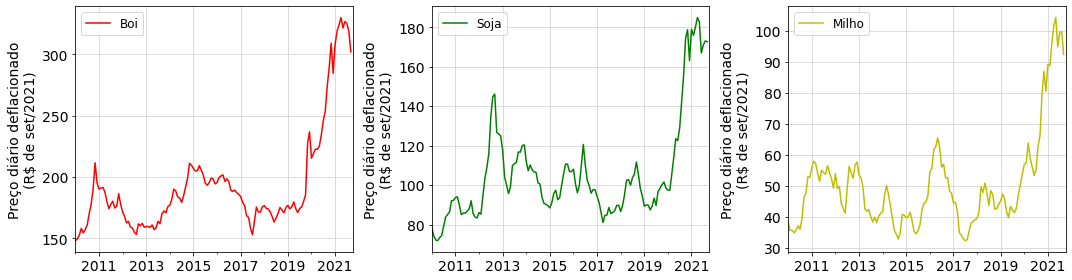

In [22]:
pl.figure(figsize=(15,4))

pl.subplot(1,3,1)
plot_cepea_prices(boi, 'Boi', 'r', preco_col='Valor IPCA')
pl.subplot(1,3,2)
plot_cepea_prices(soja, 'Soja', 'g')
pl.subplot(1,3,3)
plot_cepea_prices(milho, 'Milho', 'y')

pl.tight_layout()
pl.show()

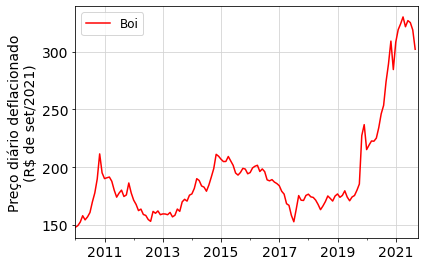

In [42]:
plot_cepea_prices(boi, 'Boi', 'r', preco_col='Valor IPCA')
#pl.savefig('../resultados/plots/preco_diario_deflacionado_boi_2010-2021.png')

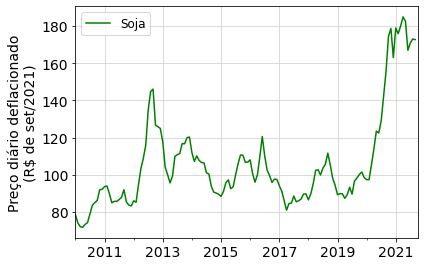

In [43]:
plot_cepea_prices(soja, 'Soja', 'g')
#pl.savefig('../resultados/plots/preco_diario_deflacionado_soja_2010-2021.png')

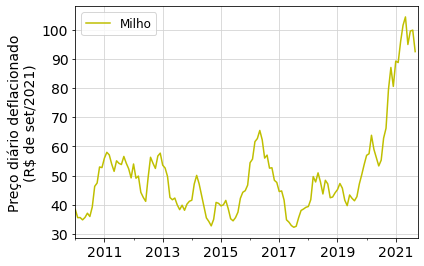

In [44]:
plot_cepea_prices(milho, 'Milho', 'y')
#pl.savefig('../resultados/plots/preco_diario_deflacionado_milho_2010-2021.png')

### Gráficos dos preços sem deflação

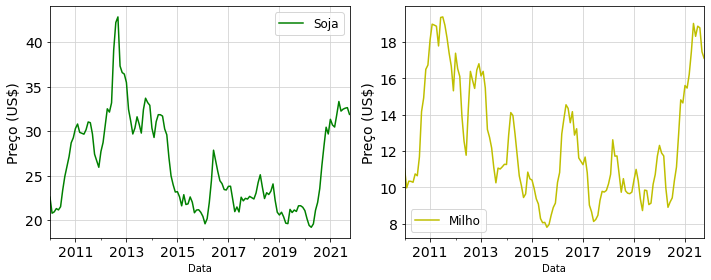

In [30]:
# Gráfico dos preços sem correção pela inflação:

pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
soja.set_index('Data')['À vista US$'].plot(label='Soja', color='g')
pl.ylabel('Preço (US$)', fontsize=14)
pl.tick_params(labelsize=14)
pl.grid(color='lightgray')
pl.legend(fontsize=12)

pl.subplot(1,2,2)
milho.set_index('Data')['À vista US$'].plot(label='Milho', color='y')
pl.ylabel('Preço (US$)', fontsize=14)
pl.tick_params(labelsize=14)
pl.grid(color='lightgray')
pl.legend(fontsize=12)

pl.tight_layout()
pl.show()

### Gráficos dos preços deflacionados médios por Ano Prodes

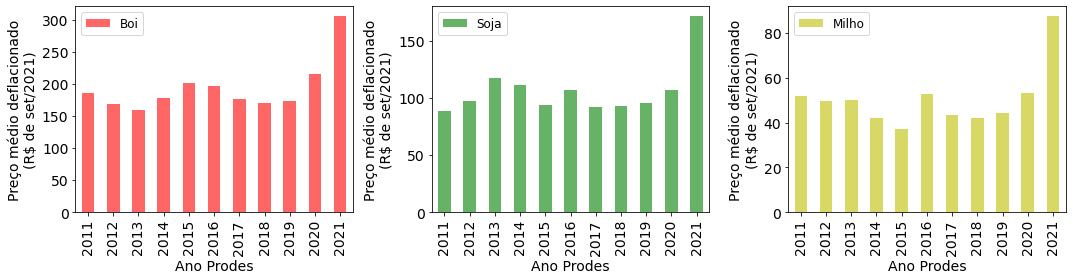

In [56]:
pl.figure(figsize=(15,4))

pl.subplot(1,3,1)
plot_cepea_anual_prices(boi_ano_prodes, 'Boi', 'r') 
pl.subplot(1,3,2)
plot_cepea_anual_prices(soja_ano_prodes, 'Soja', 'g') 
pl.subplot(1,3,3)
plot_cepea_anual_prices(milho_ano_prodes, 'Milho', 'y') 
pl.tight_layout()
pl.show()

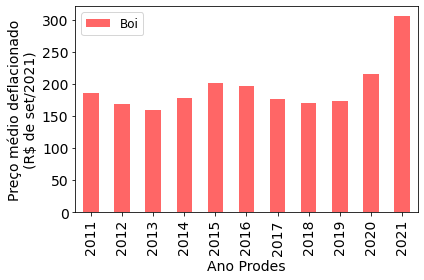

In [57]:
plot_cepea_anual_prices(boi_ano_prodes, 'Boi', 'r') 
#pl.savefig('../resultados/plots/preco_deflacionado_medio_ano_prodes_boi_2011-2021.png')

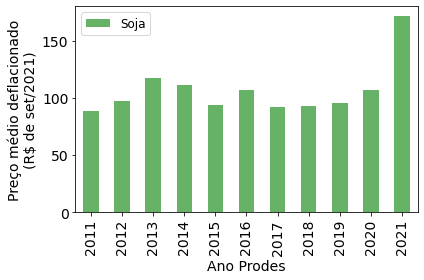

In [58]:
plot_cepea_anual_prices(soja_ano_prodes, 'Soja', 'g') 
#pl.savefig('../resultados/plots/preco_deflacionado_medio_ano_prodes_soja_2011-2021.png')

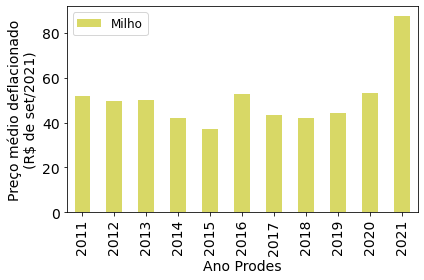

In [60]:
plot_cepea_anual_prices(milho_ano_prodes, 'Milho', 'y') 
#pl.savefig('../resultados/plots/preco_deflacionado_medio_ano_prodes_milho_2011-2021.png')

## Exploração do PIB

Aqui nós exploramos a variação temporal do PIB brasileiro, corrigido pelo IPCA.

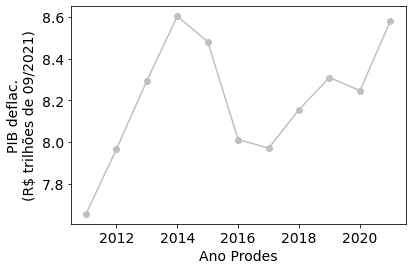

In [227]:
(pib / 1e6).plot(color='silver', marker='o')
pl.tick_params(labelsize=14)
pl.xlabel('Ano Prodes', fontsize=14)
pl.ylabel('PIB deflac.\n(R$ trilhões de 09/2021)', fontsize=14)
pl.show()

## Exploração das reservas

Aqui nós analisamos como que as reservas indígenas e unidades de conservação impactam no desmatamento

**Conclusão:** As criações de reservas são poucas no período de interesse (2010-2021), de maneira que não me parece um dado interessante para se incluir na análise

In [24]:
# Carrega dados de reservas e parques nacionais:
ucs = pd.read_csv('../dados/brutos/reservas/Base Parques nacionais.csv', skiprows=1)
# Conversão de hectares para km2:
ucs['area_geo'] = ucs['area_geo'].str.replace('.', '').astype(float) / 100

In [44]:
# Seleciona aquelas de proteção integral na amazônia
sel_ucs = ucs.loc[(ucs['biocgfun'] == 'Amazônia') & (ucs['grupo'] == 'proteção integral')]

In [48]:
# Constrói base com área total de reservas na amazônia
area_reservada = sel_ucs.groupby('criacao')['area_geo'].sum().sort_index().cumsum()
anos = list(range(2010, 2022))
pd.DataFrame(index=anos).join(area_reservada)

,area_geo
2010,NaN
2011,NaN
2012,NaN
2013,NaN
2014,306647.50
2015,NaN
2016,319202.99
2017,319993.28
2018,NaN
2019,NaN
